In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('local[2]').appName('myApp').getOrCreate()
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pyspark.ml.feature import Normalizer,VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, log, when


In [3]:
# Read the CSV file containing Titanic dataset into Spark's DataFrame and show it

df = spark.read.format('csv').options(header=True, inferSchema=True).load('Clean_Dataset.csv')
df.show(30,truncate=50)


+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|_c0|  airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|  0| SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
|  1| SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|  2|  AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|  3|  Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|  4|  Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5955|
|  5|  Vistara| UK-945|      Del

In [4]:
# Try to print the schema

df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- flight: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- price: integer (nullable = true)



| Field         | Description                                              |
|---------------|----------------------------------------------------------|
| *Airline*     | Airline                                                  |
| *Flight*      | Unique flight id                                         |
| *Source_city* | Departure city                                           |
| *Departure_time*| Departure time                                         |
| *Stops*         | Number of stops along the way                          |
| *Arrival_time*| Arrival time                                             |
| *Destination_city*| Flight destination                                   |
| *Class*       | Seating class                                            |
| *Duration*    | Overall amount of time it takes to travel between cities in hours                                |
| *Days_left*   | The number of days between the booking date and the trip date                                             |
| *Price*    | Price |

In [5]:
df.summary().show()

+-------+-----------------+-------+--------------------+-----------+--------------+------+------------+----------------+--------+------------------+------------------+------------------+
|summary|              _c0|airline|              flight|source_city|departure_time| stops|arrival_time|destination_city|   class|          duration|         days_left|             price|
+-------+-----------------+-------+--------------------+-----------+--------------+------+------------+----------------+--------+------------------+------------------+------------------+
|  count|           300153| 300153|              300153|     300153|        300153|300153|      300153|          300153|  300153|            300153|            300153|            300153|
|   mean|         150076.0|   NULL|5.427411873908628...|       NULL|          NULL|  NULL|        NULL|            NULL|    NULL|12.221020812719066|26.004750910369044|20889.660523133203|
| stddev|86646.85201148395|   NULL|1.803651814074491...|       NU

In [6]:
df.select(['airline']).groupby(['airline']).count().orderBy('count').show()

+---------+------+
|  airline| count|
+---------+------+
| SpiceJet|  9011|
|  AirAsia| 16098|
| GO_FIRST| 23173|
|   Indigo| 43120|
|Air_India| 80892|
|  Vistara|127859|
+---------+------+



EDA

In [7]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

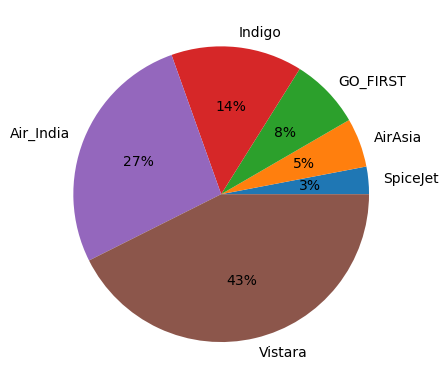

In [8]:
#showing percentage of airlines, imbalanced!
labels = ['SpiceJet','AirAsia','GO_FIRST','Indigo','Air_India','Vistara']
total = df.select(['airline']).groupby(['airline']).count().orderBy('count').toPandas()
plt.pie(data=total,labels=labels,autopct='%.0f%%',x='count')
plt.show()

In [9]:
df.select(['destination_city']).groupby(['destination_city']).count().orderBy('count').show()

+----------------+-----+
|destination_city|count|
+----------------+-----+
|         Chennai|40368|
|       Hyderabad|42726|
|         Kolkata|49534|
|       Bangalore|51068|
|           Delhi|57360|
|          Mumbai|59097|
+----------------+-----+



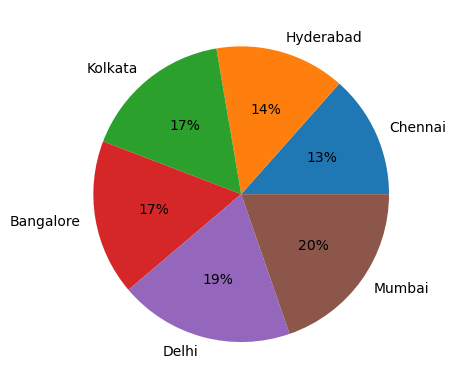

In [10]:
#showing percentage of flight destination
labels = ['Chennai','Hyderabad','Kolkata','Bangalore','Delhi','Mumbai']
total = df.select(['destination_city']).groupby(['destination_city']).count().orderBy('count').toPandas()
plt.pie(data=total,labels=labels,autopct='%.0f%%',x='count')
plt.show()

In [11]:
df.select(['source_city']).groupby(['source_city']).count().orderBy('count').show()

+-----------+-----+
|source_city|count|
+-----------+-----+
|    Chennai|38700|
|  Hyderabad|40806|
|    Kolkata|46347|
|  Bangalore|52061|
|     Mumbai|60896|
|      Delhi|61343|
+-----------+-----+



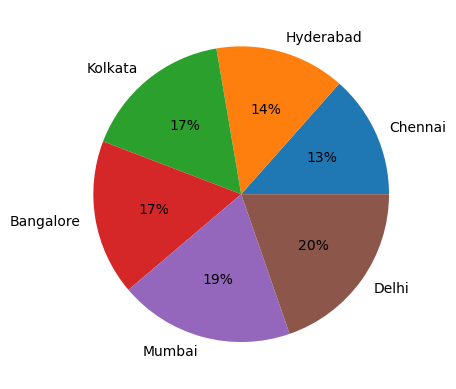

In [12]:
#showing percentage of flight source
labels = ['Chennai','Hyderabad','Kolkata','Bangalore','Mumbai','Delhi']
total = df.select(['destination_city']).groupby(['destination_city']).count().orderBy('count').toPandas()
plt.pie(data=total,labels=labels,autopct='%.0f%%',x='count')
plt.show()

In [13]:
df.select(['class']).groupby(['class']).count().orderBy('count').show()

+--------+------+
|   class| count|
+--------+------+
|Business| 93487|
| Economy|206666|
+--------+------+



<BarContainer object of 2 artists>

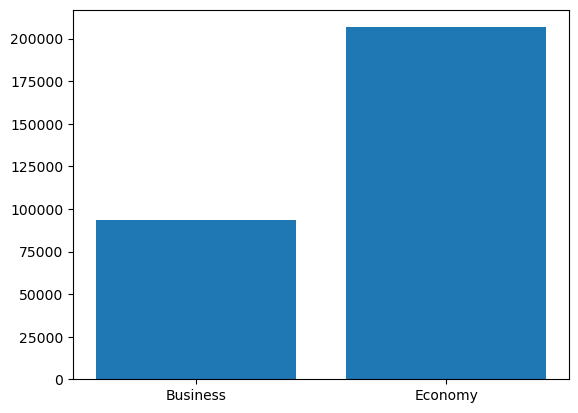

In [14]:
labels = ['Business, Economy']
t = df.select(['class']).groupby(['class']).count().orderBy('count').toPandas()
plt.bar(data=t, height='count',x='class')

In [15]:
#this shows that source and destination affects the price
#it seems that duration doesn't really affect the price if there are no stops
src_dest = df.select(['source_city','destination_city','duration','price']).\
where(df.stops=='zero').groupby(['source_city','destination_city']).\
agg(round(mean("duration"),2).alias("duration"),round(mean("price"),2).\
    alias("price")).sort(col("destination_city").desc(),col("price").desc())
src_dest.show()

+-----------+----------------+--------+--------+
|source_city|destination_city|duration|   price|
+-----------+----------------+--------+--------+
|      Delhi|          Mumbai|    2.21|11136.78|
|    Kolkata|          Mumbai|    2.85|10973.62|
|    Chennai|          Mumbai|    1.98| 9015.34|
|  Hyderabad|          Mumbai|    1.53| 7574.86|
|  Bangalore|          Mumbai|    1.79| 7519.49|
|      Delhi|         Kolkata|     2.2|11156.08|
|     Mumbai|         Kolkata|    2.64| 10672.2|
|  Hyderabad|         Kolkata|    2.04| 6026.87|
|    Chennai|         Kolkata|    2.39| 5792.92|
|  Bangalore|         Kolkata|    2.53|  4775.9|
|      Delhi|       Hyderabad|    2.22| 9775.86|
|     Mumbai|       Hyderabad|    1.44| 7232.05|
|    Kolkata|       Hyderabad|    2.21| 6135.82|
|  Bangalore|       Hyderabad|    1.22| 3041.76|
|    Chennai|       Hyderabad|    1.23| 2660.93|
|  Bangalore|           Delhi|    2.77| 13215.6|
|    Chennai|           Delhi|    2.79|12463.25|
|    Kolkata|       

In [16]:
#surprisingly flying direct is cheaper than having to transit
stop_price = df.select(['stops','price']).groupby(['stops']).agg(round(mean("price"),2).alias("price"))
stop_price.show()

+-----------+--------+
|      stops|   price|
+-----------+--------+
|two_or_more|14113.45|
|        one|22900.99|
|       zero| 9375.94|
+-----------+--------+



In [17]:
#surprisingly flying direct is cheaper than having to transit
src_dest = df.select(['source_city','destination_city','duration','stops','price']).\
groupby(['source_city','destination_city','stops']).\
agg(round(mean("duration"),2).\
    alias("duration"),round(mean("price"),2).alias("price")).\
sort(col("destination_city").desc(),col("price").desc())
src_dest.show()

+-----------+----------------+-----------+--------+--------+
|source_city|destination_city|      stops|duration|   price|
+-----------+----------------+-----------+--------+--------+
|  Bangalore|          Mumbai|        one|   12.15|25806.22|
|    Chennai|          Mumbai|        one|   13.74|24637.82|
|    Kolkata|          Mumbai|two_or_more|   16.55|23628.45|
|    Kolkata|          Mumbai|        one|   13.73| 23041.1|
|      Delhi|          Mumbai|        one|    12.9|21975.07|
|  Hyderabad|          Mumbai|        one|   12.61|21541.69|
|    Chennai|          Mumbai|two_or_more|    16.2|15491.87|
|      Delhi|          Mumbai|       zero|    2.21|11136.78|
|    Kolkata|          Mumbai|       zero|    2.85|10973.62|
|    Chennai|          Mumbai|       zero|    1.98| 9015.34|
|  Bangalore|          Mumbai|two_or_more|   15.19| 8545.72|
|      Delhi|          Mumbai|two_or_more|   10.12| 8045.74|
|  Hyderabad|          Mumbai|two_or_more|   18.59|  7912.8|
|  Hyderabad|          M

In [18]:
#this shows how when you buy the ticket will affect the price
tes = df.select(['days_left','price']).groupby(['days_left']).\
agg(round(mean("price"),2).alias("price")).sort(col("days_left").asc())
tes.show()

+---------+--------+
|days_left|   price|
+---------+--------+
|        1|21591.87|
|        2| 30211.3|
|        3|28976.08|
|        4|25730.91|
|        5|26679.77|
|        6|24856.49|
|        7|25588.37|
|        8|24895.88|
|        9|25726.25|
|       10|25572.82|
|       11|22990.66|
|       12| 22505.8|
|       13|22498.89|
|       14| 22678.0|
|       15|21952.54|
|       16|20503.55|
|       17|20386.35|
|       18|19987.45|
|       19|19507.68|
|       20|19699.98|
+---------+--------+
only showing top 20 rows



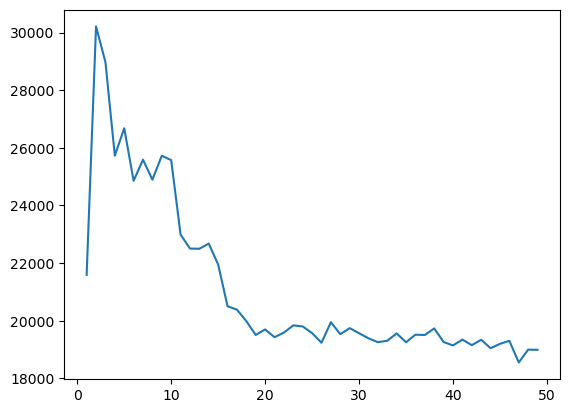

In [19]:
#interestingly if you buy your ticket the day before, its way cheaper than buying it the week before
days = tes.select(['days_left']).toPandas()
price = tes.select(['price']).toPandas()
plt.plot(days,price)

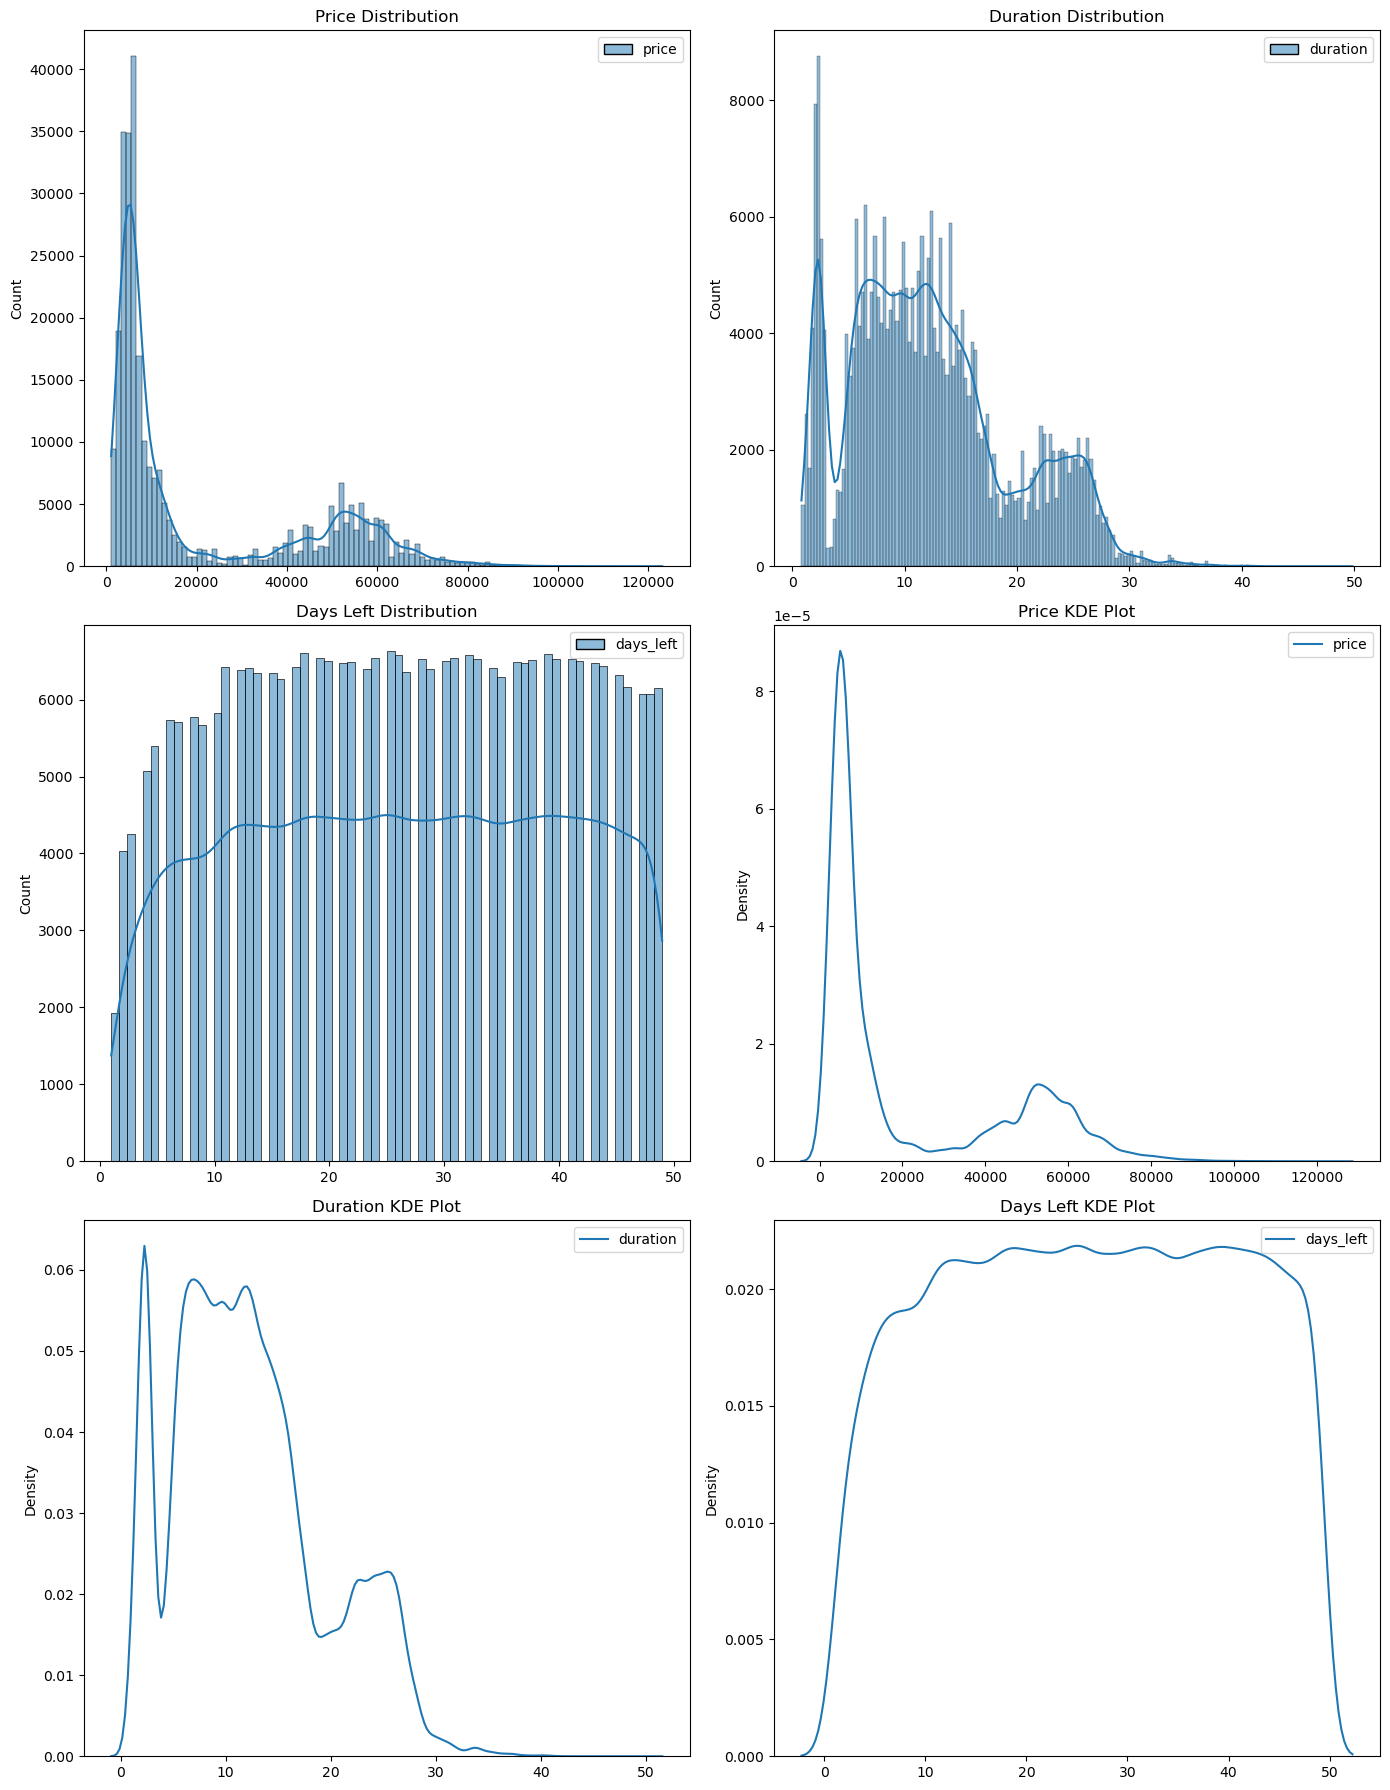

In [20]:
# Create a figure for the subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# Price distribution
sns.histplot(df.select(['price']).toPandas(), kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Price Distribution')

# Duration distribution
sns.histplot(df.select(['duration']).toPandas(), kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Duration Distribution')

# Days left distribution
sns.histplot(df.select(['days_left']).toPandas(), kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Days Left Distribution')

# Price KDE plot
sns.kdeplot(df.select(['price']).toPandas(), ax=axes[1, 1])
axes[1, 1].set_title('Price KDE Plot')

# Duration KDE plot
sns.kdeplot(df.select(['duration']).toPandas(), ax=axes[2, 0])
axes[2, 0].set_title('Duration KDE Plot')

# Days left KDE plot
sns.kdeplot(df.select(['days_left']).toPandas(), ax=axes[2, 1])
axes[2, 1].set_title('Days Left KDE Plot')

plt.tight_layout()
plt.show()

In [21]:
#no surprise business class is more expensive
seats_price = df.select(['class','price']).groupby(['class']).agg(round(mean("price"),2).alias("price"))
seats_price.show()

+--------+--------+
|   class|   price|
+--------+--------+
| Economy| 6572.34|
|Business|52540.08|
+--------+--------+



In [22]:
depart_time = df.select(['departure_time','arrival_time','price']).\
where(df.stops=="zero").groupby(['departure_time','arrival_time','price']).\
agg(round(mean("price"),2).alias("price")).sort(col('price').desc())
depart_time.show()

+--------------+------------+-----+-------+
|departure_time|arrival_time|price|  price|
+--------------+------------+-----+-------+
|       Evening|       Night|59573|59573.0|
| Early_Morning|     Morning|59509|59509.0|
|     Afternoon|     Evening|59509|59509.0|
|       Evening|       Night|59509|59509.0|
| Early_Morning|     Morning|59224|59224.0|
|       Evening|       Night|58216|58216.0|
|     Afternoon|     Evening|57084|57084.0|
|     Afternoon|     Evening|56950|56950.0|
| Early_Morning|     Morning|56950|56950.0|
| Early_Morning|     Morning|56878|56878.0|
|         Night|       Night|56878|56878.0|
|       Evening|     Evening|56878|56878.0|
|       Evening|       Night|56878|56878.0|
|       Evening|     Evening|56788|56788.0|
|       Morning|     Morning|55404|55404.0|
|       Evening|       Night|55404|55404.0|
|     Afternoon|     Evening|55278|55278.0|
|         Night|       Night|55278|55278.0|
|       Evening|       Night|55278|55278.0|
| Early_Morning|     Morning|547

In [23]:
#indexing departure time
departure_time_to_index = {
    "Late_Night": 5.0,
    "Early_Morning": 0.0,
    "Morning": 1.0,
    "Night": 4.0,
    "Evening": 3.0,
    "Afternoon": 2.0
}

def map_departure_time(departure_time):
    return departure_time_to_index.get(departure_time, None)

map_departure_time_udf = udf(map_departure_time, DoubleType())



In [24]:
df = df.withColumn("departure_time_idx", map_departure_time_udf(df["departure_time"]))
df = df.withColumn("arrival_time_idx", map_departure_time_udf(df["arrival_time"]))
df.show(30,truncate=50)

+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+------------------+----------------+
|_c0|  airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|departure_time_idx|arrival_time_idx|
+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+------------------+----------------+
|  0| SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|               3.0|             4.0|
|  1| SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|               0.0|             1.0|
|  2|  AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|               0.0|             0.0|
|  3|  Vistara| UK-995|      Delhi|       Morning| zero|  

In [25]:
#Indexing Class

df = df.withColumn(
    "class_idx",
    when(col("class") == "Economy", 0.0).otherwise(1.0)  # You can choose a different value for otherwise
)
df.show(10)

+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+------------------+----------------+---------+
|_c0| airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|departure_time_idx|arrival_time_idx|class_idx|
+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+------------------+----------------+---------+
|  0|SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|               3.0|             4.0|      0.0|
|  1|SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|               0.0|             1.0|      0.0|
|  2| AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|               0.0|             0.0|      0.0|
|  3

In [26]:
#Indexing Stops

stops_to_index = {
    "zero": 0.0,
    "one": 1.0,
    "two_or_more": 2.0,
    
}

def map_stops(stops):
    return stops_to_index.get(stops, None)

map_stops_udf = udf(map_stops, DoubleType())
df = df.withColumn("stops_idx", map_stops_udf(df["stops"]))
df.show(30,truncate=50)


+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+------------------+----------------+---------+---------+
|_c0|  airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|departure_time_idx|arrival_time_idx|class_idx|stops_idx|
+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+------------------+----------------+---------+---------+
|  0| SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|               3.0|             4.0|      0.0|      0.0|
|  1| SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|               0.0|             1.0|      0.0|      0.0|
|  2|  AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 

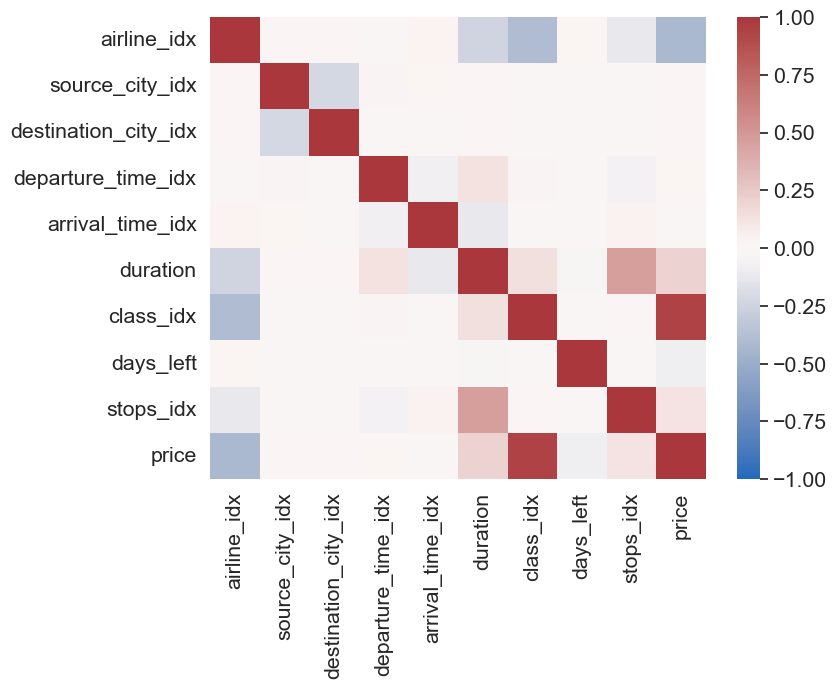

In [27]:
# from pyspark.ml.feature import StringIndexer
indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx', stringOrderType="alphabetAsc").fit(df) for col in ['source_city','destination_city']]
# indexers = StringIndexer(inputCol="departure_time", outputCol="category_index", stringOrderType="alphabetAsc")
pipeline = Pipeline(stages=indexers)
coor_df = pipeline.fit(df).transform(df)
# final_df.show()


indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(df) for col in ['airline']]
pipeline = Pipeline(stages=indexers)
coor_df = pipeline.fit(coor_df).transform(coor_df)


plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
heat = sns.heatmap(data=coor_df.select(['airline_idx', 'source_city_idx', 'destination_city_idx', 'departure_time_idx', 'arrival_time_idx','duration', 'class_idx','days_left', 'stops_idx','price']).toPandas().corr(), cmap='vlag', vmin=-1, vmax=1)

In [28]:
df.select([count(when(isnan(c) | isnull(c),1)).alias(c) for c in df.columns]).show()

+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+------------------+----------------+---------+---------+
|_c0|airline|flight|source_city|departure_time|stops|arrival_time|destination_city|class|duration|days_left|price|departure_time_idx|arrival_time_idx|class_idx|stops_idx|
+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+------------------+----------------+---------+---------+
|  0|      0|     0|          0|             0|    0|           0|               0|    0|       0|        0|    0|                 0|               0|        0|        0|
+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+------------------+----------------+---------+---------+



<h1>Data Preprocessing

In [29]:
df= df.withColumn("normalized_price", log(col("price")))
df.show(30,truncate=50)


+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+------------------+----------------+---------+---------+-----------------+
|_c0|  airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|departure_time_idx|arrival_time_idx|class_idx|stops_idx| normalized_price|
+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+------------------+----------------+---------+---------+-----------------+
|  0| SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|               3.0|             4.0|      0.0|      0.0| 8.69165057315339|
|  1| SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|               0.0|             1.0|      0.0|      0.0| 8.69165057315339|
|  2|  AirAsia| I5-764|  

In [30]:
column_name = df.columns

In [31]:
column_name.remove('_c0')
column_name.remove('price')
column_name.remove('flight')
print(column_name)

['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'departure_time_idx', 'arrival_time_idx', 'class_idx', 'stops_idx', 'normalized_price']


In [32]:
final_df = df.select(column_name)


indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(final_df) for col in ['airline']]
pipeline = Pipeline(stages=indexers)
final_df = pipeline.fit(final_df).transform(final_df)
final_df.show()

+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+------------------+----------------+---------+---------+-----------------+-----------+
|  airline|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|departure_time_idx|arrival_time_idx|class_idx|stops_idx| normalized_price|airline_idx|
+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+------------------+----------------+---------+---------+-----------------+-----------+
| SpiceJet|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1|               3.0|             4.0|      0.0|      0.0| 8.69165057315339|        5.0|
| SpiceJet|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1|               0.0|             1.0|      0.0|      0.0| 8.69165057315339|        5.0|
|  AirAsia|      Delhi| Early_Morning| zero|Early_Morni

In [33]:
# from pyspark.ml.feature import StringIndexer
indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx', stringOrderType="alphabetAsc").fit(final_df) for col in ['source_city','destination_city']]
# indexers = StringIndexer(inputCol="departure_time", outputCol="category_index", stringOrderType="alphabetAsc")
pipeline = Pipeline(stages=indexers)
final_df = pipeline.fit(final_df).transform(final_df)
final_df.show()

+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+------------------+----------------+---------+---------+-----------------+-----------+---------------+--------------------+
|  airline|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|departure_time_idx|arrival_time_idx|class_idx|stops_idx| normalized_price|airline_idx|source_city_idx|destination_city_idx|
+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+------------------+----------------+---------+---------+-----------------+-----------+---------------+--------------------+
| SpiceJet|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1|               3.0|             4.0|      0.0|      0.0| 8.69165057315339|        5.0|            2.0|                 5.0|
| SpiceJet|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|    

In [34]:
assembler = VectorAssembler(inputCols=['airline_idx', 'source_city_idx', 'departure_time_idx', 'stops_idx', 'arrival_time_idx', 'destination_city_idx', 'class_idx','duration', 'days_left'], outputCol="features")
final_df = assembler.transform(final_df)
final_df.show(30,truncate=50)

+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+------------------+----------------+---------+---------+-----------------+-----------+---------------+--------------------+---------------------------------------+
|  airline|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|departure_time_idx|arrival_time_idx|class_idx|stops_idx| normalized_price|airline_idx|source_city_idx|destination_city_idx|                               features|
+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+------------------+----------------+---------+---------+-----------------+-----------+---------------+--------------------+---------------------------------------+
| SpiceJet|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1|               3.0|             4.0|      0.0|      0.0| 8.69165057315339|        5.0|            2.

In [35]:
# Initialize the StandardScaler
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

# Fit the scaler to the data
scaler_model = scaler.fit(final_df)

# Transform the data
final_df = scaler_model.transform(final_df)

final_df.show(10,truncate=10)

+--------+-----------+--------------+-----+------------+----------------+-------+--------+---------+------------------+----------------+---------+---------+----------------+-----------+---------------+--------------------+----------+--------------+
| airline|source_city|departure_time|stops|arrival_time|destination_city|  class|duration|days_left|departure_time_idx|arrival_time_idx|class_idx|stops_idx|normalized_price|airline_idx|source_city_idx|destination_city_idx|  features|scaledFeatures|
+--------+-----------+--------------+-----+------------+----------------+-------+--------+---------+------------------+----------------+---------+---------+----------------+-----------+---------------+--------------------+----------+--------------+
|SpiceJet|      Delhi|       Evening| zero|       Night|          Mumbai|Economy|    2.17|        1|               3.0|             4.0|      0.0|      0.0|      8.69165...|        5.0|            2.0|                 5.0|[5.0,2....|    [2.8530...|
|Spi

In [36]:
from pyspark.ml.feature import PCA


pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcafeatures")
model = pca.fit(final_df)

# Step 5: Transform Data
final_df = model.transform(final_df)


In [37]:
final_df.show(10, truncate=50)

+--------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+------------------+----------------+---------+---------+-----------------+-----------+---------------+--------------------+--------------------------------------+--------------------------------------------------+-----------------------------------------+
| airline|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|departure_time_idx|arrival_time_idx|class_idx|stops_idx| normalized_price|airline_idx|source_city_idx|destination_city_idx|                              features|                                    scaledFeatures|                              pcafeatures|
+--------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+------------------+----------------+---------+---------+-----------------+-----------+---------------+--------------------+--------------------------------------+-----------------------

In [38]:
feature_vector_df = final_df.select(['features','pcafeatures', 'normalized_price'])
feature_vector_df.show(truncate=False)

+---------------------------------------+-----------------------------------------+-----------------+
|features                               |pcafeatures                              |normalized_price |
+---------------------------------------+-----------------------------------------+-----------------+
|[5.0,2.0,3.0,0.0,4.0,5.0,0.0,2.17,1.0] |[-3.545035799804864,-1.0677816822969162] |8.69165057315339 |
|[5.0,2.0,0.0,0.0,1.0,5.0,0.0,2.33,1.0] |[-3.4882736520760136,-1.4533056995055893]|8.69165057315339 |
|[4.0,2.0,0.0,0.0,0.0,5.0,0.0,2.17,1.0] |[-3.0365518499028767,-1.6432726034953962]|8.6921543938039  |
|[0.0,2.0,1.0,0.0,2.0,5.0,0.0,2.25,1.0] |[-1.619246068775661,-1.6881310794064068] |8.691986481789401|
|[0.0,2.0,1.0,0.0,1.0,5.0,0.0,2.33,1.0] |[-1.5259328446726015,-1.8034142542555254]|8.691986481789401|
|[0.0,2.0,1.0,0.0,2.0,5.0,0.0,2.33,1.0] |[-1.6127070636261442,-1.6874434480382432]|8.691986481789401|
|[0.0,2.0,1.0,0.0,1.0,5.0,0.0,2.08,1.0] |[-1.5463672357648413,-1.8055631022810368]

<h3> Regression Model

In [39]:
from pyspark.ml.evaluation import RegressionEvaluator

In [40]:
(trainData, testData) = feature_vector_df.randomSplit([0.8,0.2],seed = 2)

In [41]:
trainData.show(10,truncate=False)

+---------------------------------+-----------------------------------------+-----------------+
|features                         |pcafeatures                              |normalized_price |
+---------------------------------+-----------------------------------------+-----------------+
|(9,[0,1,7,8],[2.0,2.0,2.75,45.0])|[-2.3706946451122364,0.17761195813157393]|8.411832675758411|
|(9,[0,1,7,8],[2.0,2.0,2.75,46.0])|[-2.3749846946359177,0.17796950221165786]|8.411832675758411|
|(9,[0,1,7,8],[2.0,2.0,2.75,47.0])|[-2.379274744159599,0.17832704629174176] |8.411832675758411|
|(9,[0,1,7,8],[2.0,2.0,2.75,48.0])|[-2.3835647936832802,0.17868459037182569]|8.411832675758411|
|(9,[0,1,7,8],[5.0,2.0,2.5,5.0])  |[-3.353603835813109,0.3790238520112982]  |8.9126079636709  |
|(9,[0,1,7,8],[5.0,2.0,2.5,6.0])  |[-3.3578938853367903,0.3793813960913821] |8.9126079636709  |
|(9,[0,1,7,8],[5.0,2.0,2.5,8.0])  |[-3.366473984384153,0.38009648425154996] |8.9126079636709  |
|(9,[0,1,7,8],[5.0,2.0,2.5,9.0])  |[-3.3

In [42]:
testData.show(1,truncate=False)

+---------------------------------+----------------------------------------+-----------------+
|features                         |pcafeatures                             |normalized_price |
+---------------------------------+----------------------------------------+-----------------+
|(9,[0,1,7,8],[2.0,2.0,2.75,49.0])|[-2.3878548432069615,0.1790421344519096]|8.411832675758411|
+---------------------------------+----------------------------------------+-----------------+
only showing top 1 row



In [43]:
max_value = df.select(max('days_left')).rdd.flatMap(lambda x: x).first()
max_value


49

In [44]:
testData.show(1,truncate=False)

+---------------------------------+----------------------------------------+-----------------+
|features                         |pcafeatures                             |normalized_price |
+---------------------------------+----------------------------------------+-----------------+
|(9,[0,1,7,8],[2.0,2.0,2.75,49.0])|[-2.3878548432069615,0.1790421344519096]|8.411832675758411|
+---------------------------------+----------------------------------------+-----------------+
only showing top 1 row



<h5> XGBoost

In [45]:
from pyspark.ml.regression import GBTRegressor
import xgboost as xg
import sklearn
import numpy as np

xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123).fit(np.vstack(trainData.select("features").collect()), np.vstack(trainData.select("normalized_price").collect()))

C:\Users\Alfred\anaconda3\envs\kuliah\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:10:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [46]:
pred = xgb_r.predict(np.vstack(testData.select("features").collect()))
pred

array([ 8.119157,  8.397772,  8.760262, ..., 10.742799, 10.815035,
       10.83775 ], dtype=float32)

In [47]:
from pyspark.sql.functions import monotonically_increasing_id

test_pred = spark.createDataFrame(pred)

testData_pred = testData.withColumn('key', monotonically_increasing_id())
test_pred = test_pred.withColumn('key', monotonically_increasing_id())

test_pred = test_pred.withColumn("prediction", test_pred["value"])
# Perform the join on the key column
test_with_pred = testData_pred.join(test_pred, on='key')


test_with_pred = test_with_pred.drop('key')
test_with_pred = test_with_pred.drop('value')

test_with_pred.show(10, truncate=50)

+---------------------------------+-----------------------------------------+-----------------+----------+
|                         features|                              pcafeatures| normalized_price|prediction|
+---------------------------------+-----------------------------------------+-----------------+----------+
|(9,[0,1,7,8],[2.0,2.0,2.75,49.0])| [-2.3878548432069615,0.1790421344519096]|8.411832675758411|  8.119157|
| (9,[0,1,7,8],[5.0,2.0,2.5,16.0])|  [-3.400794380573603,0.3829568368922213]|8.459775920546287|  8.397772|
|(9,[1,4,7,8],[2.0,1.0,2.75,15.0])|[-1.5727161913180836,0.13761477187394344]|8.412054873292933|  8.760262|
|(9,[1,4,7,8],[2.0,1.0,2.75,18.0])|[-1.5855863398891274,0.13868740411419522]|8.412054873292933|   8.21384|
|(9,[1,4,7,8],[2.0,1.0,2.75,21.0])|[-1.5984564884601713,0.13976003635444698]|8.412054873292933|   8.21384|
|(9,[1,4,7,8],[2.0,1.0,2.75,24.0])|[-1.6113266370312151,0.14083266859469873]|8.412054873292933|   8.21384|
|(9,[1,4,7,8],[2.0,1.0,2.75,29.0])|[-

In [48]:
evaluator = RegressionEvaluator(labelCol='normalized_price', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(test_with_pred)
print ("Root Mean Square of XGBoost model is %g"%rmse)

Root Mean Square of XGBoost model is 1.37052


In [49]:
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123).fit(np.vstack(trainData.select("pcafeatures").collect()), np.vstack(trainData.select("normalized_price").collect()))

C:\Users\Alfred\anaconda3\envs\kuliah\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:11:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [50]:
pred = xgb_r.predict(np.vstack(testData.select("pcafeatures").collect()))
pred

array([ 8.370245,  8.030391,  8.624785, ..., 10.223016, 10.48164 ,
       10.640965], dtype=float32)

In [51]:
from pyspark.sql.functions import monotonically_increasing_id

test_pred = spark.createDataFrame(pred)

testData_pred = testData.withColumn('key', monotonically_increasing_id())
test_pred = test_pred.withColumn('key', monotonically_increasing_id())

test_pred = test_pred.withColumn("prediction", test_pred["value"])
# Perform the join on the key column
test_with_pred = testData_pred.join(test_pred, on='key')


test_with_pred_2 = test_with_pred.drop('key')

test_with_pred_2.show(10, truncate=50)

+---------------------------------+-----------------------------------------+-----------------+--------+----------+
|                         features|                              pcafeatures| normalized_price|   value|prediction|
+---------------------------------+-----------------------------------------+-----------------+--------+----------+
|(9,[0,1,7,8],[2.0,2.0,2.75,49.0])| [-2.3878548432069615,0.1790421344519096]|8.411832675758411|8.370245|  8.370245|
| (9,[0,1,7,8],[5.0,2.0,2.5,16.0])|  [-3.400794380573603,0.3829568368922213]|8.459775920546287|8.030391|  8.030391|
|(9,[1,4,7,8],[2.0,1.0,2.75,15.0])|[-1.5727161913180836,0.13761477187394344]|8.412054873292933|8.624785|  8.624785|
|(9,[1,4,7,8],[2.0,1.0,2.75,18.0])|[-1.5855863398891274,0.13868740411419522]|8.412054873292933|8.531222|  8.531222|
|(9,[1,4,7,8],[2.0,1.0,2.75,21.0])|[-1.5984564884601713,0.13976003635444698]|8.412054873292933|8.531222|  8.531222|
|(9,[1,4,7,8],[2.0,1.0,2.75,24.0])|[-1.6113266370312151,0.14083266859469

In [52]:
evaluator = RegressionEvaluator(labelCol='normalized_price', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(test_with_pred_2)
print ("Root Mean Square of XGBoost model is %g"%rmse)

Root Mean Square of XGBoost model is 1.22688


<h5> Support Vector Regressor

In [53]:
# from sklearn.svm import SVR
from sklearn.svm import LinearSVR

In [54]:
svr = LinearSVR(random_state=0,tol=1e-6,epsilon=0, C=0.8,dual=True)

In [55]:
svr_model = svr.fit(np.vstack(trainData.select("pcafeatures").collect()),np.vstack(trainData.select("normalized_price").collect()))

C:\Users\Alfred\anaconda3\envs\kuliah\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Alfred\anaconda3\envs\kuliah\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [56]:
y_pred = svr.predict(np.vstack(testData.select("pcafeatures").collect()))

In [57]:
from pyspark.sql.functions import monotonically_increasing_id

test_pred = spark.createDataFrame(y_pred)

testData_pred = testData.withColumn('key', monotonically_increasing_id())
test_pred = test_pred.withColumn('key', monotonically_increasing_id())

test_pred = test_pred.withColumn("prediction", test_pred["value"])
# Perform the join on the key column
test_with_pred = testData_pred.join(test_pred, on='key')


test_with_pred = test_with_pred.drop('key')
test_with_pred = test_with_pred.drop('value')

test_with_pred.show(10, truncate=50)

+---------------------------------+-----------------------------------------+-----------------+-----------------+
|                         features|                              pcafeatures| normalized_price|       prediction|
+---------------------------------+-----------------------------------------+-----------------+-----------------+
|(9,[0,1,7,8],[2.0,2.0,2.75,49.0])| [-2.3878548432069615,0.1790421344519096]|8.411832675758411|7.803777630974852|
| (9,[0,1,7,8],[5.0,2.0,2.5,16.0])|  [-3.400794380573603,0.3829568368922213]|8.459775920546287|7.138829232135414|
|(9,[1,4,7,8],[2.0,1.0,2.75,15.0])|[-1.5727161913180836,0.13761477187394344]|8.412054873292933|8.321193974026494|
|(9,[1,4,7,8],[2.0,1.0,2.75,18.0])|[-1.5855863398891274,0.13868740411419522]|8.412054873292933|8.312964195292135|
|(9,[1,4,7,8],[2.0,1.0,2.75,21.0])|[-1.5984564884601713,0.13976003635444698]|8.412054873292933|8.304734416557778|
|(9,[1,4,7,8],[2.0,1.0,2.75,24.0])|[-1.6113266370312151,0.14083266859469873]|8.412054873

In [58]:
evaluator = RegressionEvaluator(labelCol='normalized_price', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(test_with_pred)
print ("Root Mean Square of SVR model is %g"%rmse)

Root Mean Square of SVR model is 1.26505


<h5> Random Forest Regressor

In [59]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features',labelCol='normalized_price').fit(trainData)
prediction = rf.transform(testData)

In [60]:
prediction.show(10, truncate=50)

+---------------------------------+-----------------------------------------+-----------------+-----------------+
|                         features|                              pcafeatures| normalized_price|       prediction|
+---------------------------------+-----------------------------------------+-----------------+-----------------+
|(9,[0,1,7,8],[2.0,2.0,2.75,49.0])| [-2.3878548432069615,0.1790421344519096]|8.411832675758411| 8.16020567390061|
| (9,[0,1,7,8],[5.0,2.0,2.5,16.0])|  [-3.400794380573603,0.3829568368922213]|8.459775920546287|8.262691979603021|
|(9,[1,4,7,8],[2.0,1.0,2.75,15.0])|[-1.5727161913180836,0.13761477187394344]|8.412054873292933|8.840239141565538|
|(9,[1,4,7,8],[2.0,1.0,2.75,18.0])|[-1.5855863398891274,0.13868740411419522]|8.412054873292933| 8.34276503776712|
|(9,[1,4,7,8],[2.0,1.0,2.75,21.0])|[-1.5984564884601713,0.13976003635444698]|8.412054873292933| 8.34276503776712|
|(9,[1,4,7,8],[2.0,1.0,2.75,24.0])|[-1.6113266370312151,0.14083266859469873]|8.412054873

In [61]:
evaluator = RegressionEvaluator(labelCol='normalized_price', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(prediction)
print ("Root Mean Square of Random Forest model is %g"%rmse)

Root Mean Square of Random Forest model is 0.287148


PCAed features

In [62]:
rf_pca = RandomForestRegressor(featuresCol='pcafeatures',labelCol='normalized_price').fit(trainData)
prediction_pca = rf_pca.transform(testData)

In [63]:
prediction_pca.show(10, truncate=50)

+---------------------------------+-----------------------------------------+-----------------+-----------------+
|                         features|                              pcafeatures| normalized_price|       prediction|
+---------------------------------+-----------------------------------------+-----------------+-----------------+
|(9,[0,1,7,8],[2.0,2.0,2.75,49.0])| [-2.3878548432069615,0.1790421344519096]|8.411832675758411|8.378929346164574|
| (9,[0,1,7,8],[5.0,2.0,2.5,16.0])|  [-3.400794380573603,0.3829568368922213]|8.459775920546287|8.353812944943785|
|(9,[1,4,7,8],[2.0,1.0,2.75,15.0])|[-1.5727161913180836,0.13761477187394344]|8.412054873292933| 8.40171641982379|
|(9,[1,4,7,8],[2.0,1.0,2.75,18.0])|[-1.5855863398891274,0.13868740411419522]|8.412054873292933| 8.40171641982379|
|(9,[1,4,7,8],[2.0,1.0,2.75,21.0])|[-1.5984564884601713,0.13976003635444698]|8.412054873292933| 8.40171641982379|
|(9,[1,4,7,8],[2.0,1.0,2.75,24.0])|[-1.6113266370312151,0.14083266859469873]|8.412054873

In [64]:
evaluator = RegressionEvaluator(labelCol='normalized_price', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(prediction_pca)
print ("Root Mean Square of Random Forest model is %g"%rmse)

Root Mean Square of Random Forest model is 0.788117


In [65]:
airline = final_df.select(['airline','airline_idx']).distinct()
airline.show(10)

+---------+-----------+
|  airline|airline_idx|
+---------+-----------+
|Air_India|        1.0|
|   Indigo|        2.0|
|  Vistara|        0.0|
|  AirAsia|        4.0|
| SpiceJet|        5.0|
| GO_FIRST|        3.0|
+---------+-----------+



In [66]:
city = final_df.select(['source_city','source_city_idx']).distinct()
city.show(10)

+-----------+---------------+
|source_city|source_city_idx|
+-----------+---------------+
|     Mumbai|            5.0|
|      Delhi|            2.0|
|  Bangalore|            0.0|
|    Kolkata|            4.0|
|  Hyderabad|            3.0|
|    Chennai|            1.0|
+-----------+---------------+



In [67]:
time = final_df.select(['departure_time','departure_time_idx']).distinct()
time.show(10)

+--------------+------------------+
|departure_time|departure_time_idx|
+--------------+------------------+
|     Afternoon|               2.0|
|         Night|               4.0|
| Early_Morning|               0.0|
|    Late_Night|               5.0|
|       Morning|               1.0|
|       Evening|               3.0|
+--------------+------------------+



In [68]:
stop = final_df.select(['stops','stops_idx']).distinct()
stop.show(10)

+-----------+---------+
|      stops|stops_idx|
+-----------+---------+
|        one|      1.0|
|two_or_more|      2.0|
|       zero|      0.0|
+-----------+---------+



In [69]:
classdf = final_df.select(['class','class_idx']).distinct()
classdf.show(10)

+--------+---------+
|   class|class_idx|
+--------+---------+
| Economy|      0.0|
|Business|      1.0|
+--------+---------+



In [70]:
#best model = Random Forest without PCA
# departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
airline_input = input("Airline = ")
flight_input = input("flight = ")
sc_city_input = input("source city = ")
dpt_time_input = input("departure time = ")
stops_input = input("stops = ")
arrival_time_input = input("arrival time = ")
dst_city_input = input("destination city = ")
class_input = input("class = ")
duration_input = input("duration = ")
days_left_input = input("days left = ")

Airline =  5
flight =  
source city =  2
departure time =  3
stops =  0
arrival time =  4
destination city =  5
class =  0
duration =  2.17
days left =  1


In [71]:
import pandas as pd

In [72]:
data_usr = {
    "airline": [float(airline_input)],
    "flight": [flight_input],
    "source_city": [float(sc_city_input)],
    "departure_time": [float(dpt_time_input)],
    "stops": [float(stops_input)],
    "arrival_time": [float(arrival_time_input)],
    "destination_city": [float(dst_city_input)],
    "class": [float(class_input)],
    "duration": [float(duration_input)],
    "days_left": [float(days_left_input)]
}

pandas_df_usr = pd.DataFrame(data_usr)
spark_df_usr = spark.createDataFrame(pandas_df_usr)

spark_df_usr.show()

+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+
|airline|flight|source_city|departure_time|stops|arrival_time|destination_city|class|duration|days_left|
+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+
|    5.0|      |        2.0|           3.0|  0.0|         4.0|             5.0|  0.0|    2.17|      1.0|
+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+



In [73]:
column_name_input = spark_df_usr.columns
column_name_input.remove("flight")

In [74]:
final_df_input = spark_df_usr.select(column_name_input)


# indexers_input = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(final_df_input) for col in ['airline','source_city','departure_time', 'stops', 'arrival_time', 'destination_city','class']]
# pipeline_input = Pipeline(stages=indexers_input)
# final_df_input = pipeline_input.fit(final_df_input).transform(final_df_input)
# final_df_input.show()

In [75]:
assembler = VectorAssembler(inputCols=['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class','duration', 'days_left'], outputCol="features")
# assembler = VectorAssembler(inputCols=['airline_idx', 'source_city_idx', 'departure_time_idx', 'stops_idx', 'arrival_time_idx', 'destination_city_idx', 'class_idx','duration', 'days_left'], outputCol="features")
final_df_input = assembler.transform(final_df_input)
final_df_input.show()

+-------+-----------+--------------+-----+------------+----------------+-----+--------+---------+--------------------+
|airline|source_city|departure_time|stops|arrival_time|destination_city|class|duration|days_left|            features|
+-------+-----------+--------------+-----+------------+----------------+-----+--------+---------+--------------------+
|    5.0|        2.0|           3.0|  0.0|         4.0|             5.0|  0.0|    2.17|      1.0|[5.0,2.0,3.0,0.0,...|
+-------+-----------+--------------+-----+------------+----------------+-----+--------+---------+--------------------+



In [76]:
scaler_input = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

# Fit the scaler to the data
scaler_model_input = scaler_input.fit(final_df_input)

# Transform the data
final_df_input = scaler_model_input.transform(final_df_input)

final_df_input.show(10,truncate=False)

+-------+-----------+--------------+-----+------------+----------------+-----+--------+---------+--------------------------------------+-------------------------------------+
|airline|source_city|departure_time|stops|arrival_time|destination_city|class|duration|days_left|features                              |scaledFeatures                       |
+-------+-----------+--------------+-----+------------+----------------+-----+--------+---------+--------------------------------------+-------------------------------------+
|5.0    |2.0        |3.0           |0.0  |4.0         |5.0             |0.0  |2.17    |1.0      |[5.0,2.0,3.0,0.0,4.0,5.0,0.0,2.17,1.0]|[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]|
+-------+-----------+--------------+-----+------------+----------------+-----+--------+---------+--------------------------------------+-------------------------------------+



In [77]:
feature_vector_df_input = final_df_input.select(['features'])
feature_vector_df_input.show(truncate=False)

+--------------------------------------+
|features                              |
+--------------------------------------+
|[5.0,2.0,3.0,0.0,4.0,5.0,0.0,2.17,1.0]|
+--------------------------------------+



In [78]:
prediction_input = rf.transform(feature_vector_df_input)
prediction_input.show()

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[5.0,2.0,3.0,0.0,...|8.744619342440647|
+--------------------+-----------------+



In [79]:
from pyspark.sql.functions import exp
prediction_input = prediction_input.withColumn("normalized_price", exp(col("prediction")))
prediction_input.show()

+--------------------+-----------------+-----------------+
|            features|       prediction| normalized_price|
+--------------------+-----------------+-----------------+
|[5.0,2.0,3.0,0.0,...|8.744619342440647|6276.823644658233|
+--------------------+-----------------+-----------------+



In [80]:
# spark.stop